In [1]:
import numpy as np
import pandas as pd
import mrcfile
import matplotlib.pyplot as plt

from torch_find_peaks import find_peaks_3d
from fle_3d import FLEBasis3D

In [2]:
# Choosing one large protein (per recommendation)
TEMPLATE_PATH = "5MRC_10.00A_solvent-4.530V_real.mrc"

with mrcfile.open(TEMPLATE_PATH, permissive=True) as m:
    template = m.data.astype(np.float32)

print("Template shape:", template.shape)

Template shape: (37, 37, 37)


/workspaces/fle3d-experiment1/.venv/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:206: RuntimeWarning: Map ID string not found - not an MRC file, or file is corrupt
  warnings.warn(msg, RuntimeWarning)


In [3]:
# building fle 3d and RI volume

fle = FLEBasis3D(
    N=template.shape[0],
    bandlimit=32,
    eps=1e-4
)

def rotation_invariant_volume(fle, volume):
    coeffs = fle.evaluate_t(volume)
    coeffs_tmp = np.zeros_like(coeffs)
    for k in fle.idlm_list[0][0]:   # l=0, m=0 only
        coeffs_tmp[k] = coeffs[k]
    return fle.evaluate(coeffs_tmp).real

template_ri = rotation_invariant_volume(fle, template)

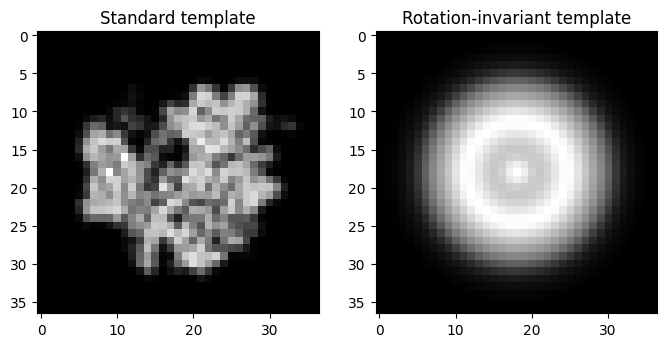

In [4]:
mid = template.shape[0] // 2

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(template[mid], cmap="gray")
axs[0].set_title("Standard template")

axs[1].imshow(template_ri[mid], cmap="gray")
axs[1].set_title("Rotation-invariant template")

plt.show()

In [5]:
with mrcfile.open("grandmodel.mrc", permissive=True) as m:
    grand_model = m.data.astype(np.float32)

with mrcfile.open("reconstruction.mrc", permissive=True) as m:
    reconstruction = m.data.astype(np.float32)

print("Grand model shape:", grand_model.shape)
print("Reconstruction shape:", reconstruction.shape)

/workspaces/fle3d-experiment1/.venv/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:206: RuntimeWarning: Map ID string not found - not an MRC file, or file is corrupt
  warnings.warn(msg, RuntimeWarning)
/workspaces/fle3d-experiment1/.venv/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:216: RuntimeWarning: Unrecognised machine stamp: 0x00 0x00 0x00 0x00
  warnings.warn(str(err), RuntimeWarning)


Grand model shape: (180, 512, 512)
Reconstruction shape: (512, 512, 512)


In [6]:
def compute_cc2(volume, ref):
    # zero-pad template to volume size
    pad = np.zeros_like(volume)
    sz = ref.shape[0]
    pad[:sz, :sz, :sz] = ref

    F_vol = np.fft.fftn(volume)
    F_ref = np.fft.fftn(pad)

    cc = np.real(np.fft.ifftn(F_vol * np.conj(F_ref)))
    return cc

In [7]:
import torch    
def compute_cc(vol, ref):
    ref_original_shape = ref.shape
    if ref.shape != vol.shape:
        # Apply zero-padding to the smaller volume
        max_shape = np.maximum(ref.shape, vol.shape)
        ref_padded = np.zeros(max_shape, dtype=ref.dtype)
        vol_padded = np.zeros(max_shape, dtype=vol.dtype)
        ref_padded[:ref.shape[0], :ref.shape[1], :ref.shape[2]] = ref
        vol_padded[:vol.shape[0], :vol.shape[1], :vol.shape[2]] = vol
        ref, vol = ref_padded, vol_padded
    assert ref.shape == vol.shape, "Volumes must have the same shape after padding."
    print("Computing CC for volumes of shape:", ref.shape)
    if torch.cuda.is_available():
        vol = torch.tensor(vol, device='cuda')
        ref = torch.tensor(ref, device='cuda')
        F1 = torch.fft.fftn(ref)
        F2 = torch.fft.fftn(vol)
        cc = torch.fft.ifftn(F2 * torch.conj(F1))
        cc= torch.real(cc).cpu().numpy()    
    else:
        F1 = np.fft.fftn(ref)
        F2 = np.fft.fftn(vol)
        cc = np.fft.ifftn(F2 * np.conj(F1))
        cc= np.real(cc)
    cc = np.roll(cc, shift=(ref_original_shape[0]//2, ref_original_shape[1]//2, ref_original_shape[2]//2), axis=(0,1,2))
    return cc , ref

In [8]:
#cc_std = compute_cc(grand_model, template)
#cc_ri  = compute_cc(grand_model, template_ri)





cc_std, ref_padded = compute_cc(grand_model, template)

cc_ri, ref_padded_ri = compute_cc(grand_model, template_ri)
cc_std = np.maximum(cc_std, 0)
cc_ri  = np.maximum(cc_ri, 0)
print("CC volumes computed")

Computing CC for volumes of shape: (180, 512, 512)


Computing CC for volumes of shape: (180, 512, 512)
CC volumes computed


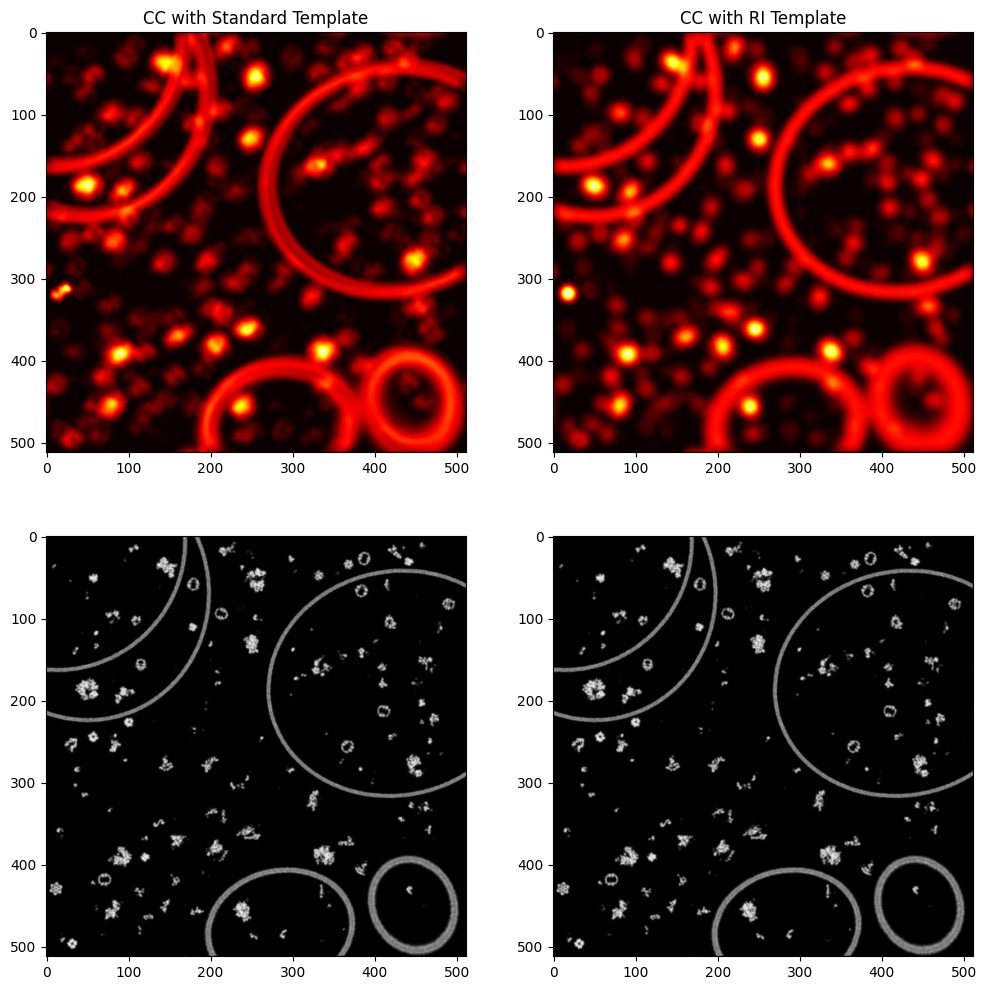

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(12,12))
mid = cc_std.shape[0] // 2
ax[0, 0].imshow(cc_std[mid], cmap="hot")
ax[0, 0].set_title("CC with Standard Template")
ax[0, 1].imshow(cc_ri[mid], cmap="hot")
ax[0, 1].set_title("CC with RI Template")
ax[1,0].imshow(grand_model[mid], cmap="gray")
ax[1,1].imshow(grand_model[mid], cmap="gray")

In [10]:
print("Tomogram shape:", reconstruction.shape)
print("Template shape:", template.shape, template_ri.shape)

Tomogram shape: (512, 512, 512)
Template shape: (37, 37, 37) (37, 37, 37)


In [11]:
from torch_find_peaks import find_peaks_3d

# Detect peaks
peaks_std = find_peaks_3d(
    cc_std,
    min_distance=1,
    threshold_abs=0.01,
    return_as="torch"
)

peaks_ri = find_peaks_3d(
    cc_ri,
    min_distance=1,
    threshold_abs=0.01,
    return_as="torch"
)

print("STD peaks:", peaks_std[0].shape)
print("RI  peaks:", peaks_ri[0].shape)

STD peaks: torch.Size([6651, 3])
RI  peaks: torch.Size([3556, 3])


tensor([[  0,   0, 390],
        [  0,  13, 459],
        [  0,  16, 502],
        ...,
        [179, 497, 310],
        [179, 511,  66],
        [179, 511, 151]])
80


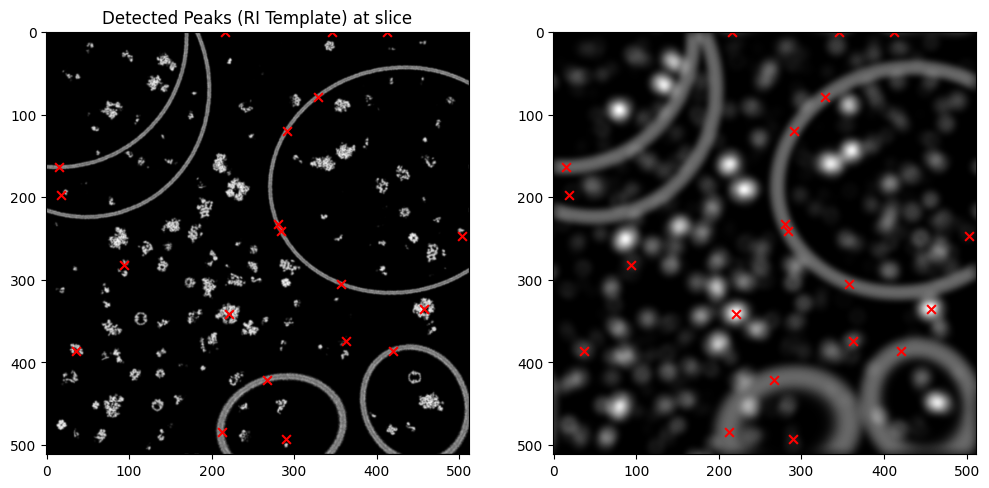

In [14]:
print(peaks_ri[0])

slice_id = 80
print(slice_id)


#x_coord, y_coord = y_coord, x_coord  # swapped in pea
# ks

#print(sl)
# take all peaks that are at mid slice
subset_mask = peaks_ri[0][:,0] == slice_id
subset_peaks_ri = peaks_ri[0][subset_mask]

# Mark the peaks on the image
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].imshow(grand_model[slice_id], cmap="gray")
ax[0].scatter(subset_peaks_ri[:,2], subset_peaks_ri[:,1], c='r', s=40, marker='x')
ax[0].set_title("Detected Peaks (RI Template) at slice")
ax[1].imshow(cc_ri[slice_id], cmap="gray")
ax[1].scatter(subset_peaks_ri[:,2], subset_peaks_ri[:,1], c='r', s=40, marker='x')

In [15]:
TOPK = 150 # checking with different values
top_std = peaks_std[0][peaks_std[1].argsort(descending=True)[:TOPK]] # is size of template,shape[0] //2

print(cc_ri.shape)
top_ri  = peaks_ri[0][peaks_ri[1].argsort(descending=True)[:TOPK]]# is size of template,shape[0] //2

print("Top peaks (ri):", top_ri)

#print("scores (ri):", peaks_ri[1][peaks_ri[1].argsort(descending=True)[:TOPK]])

(180, 512, 512)
Top peaks (ri): tensor([[ 53, 424, 317],
        [ 53, 423, 320],
        [ 56, 427, 319],
        [ 55, 426, 321],
        [ 44, 382, 290],
        [ 44, 379, 291],
        [ 43, 382, 295],
        [ 59, 252, 109],
        [ 55, 249, 103],
        [124, 323, 378],
        [127, 331, 374],
        [ 94, 316,  19],
        [101, 321,  16],
        [163, 358, 234],
        [163, 360, 235],
        [116, 456, 324],
        [133, 339, 236],
        [ 98, 370, 162],
        [130, 120,  60],
        [ 97, 195,  93],
        [106,  84, 360],
        [ 73, 238, 152],
        [ 73, 378, 198],
        [123, 480, 285],
        [106,  79, 474],
        [126, 429,  69],
        [135, 444, 151],
        [ 36, 384, 332],
        [141, 352, 384],
        [ 47, 268,  58],
        [ 68, 230, 404],
        [ 63,  47,  66],
        [ 92,  54, 256],
        [131, 181, 412],
        [110, 341, 487],
        [145,  19, 425],
        [ 28, 480, 148],
        [ 94, 280, 450],
        [128, 319,

In [16]:
import pandas as pd

gt = pd.read_csv(
    "particle_locations.txt",
    sep=r"\s+",
    header=None,
    names=["label", "z", "y", "x", "rot1", "rot2", "rot3"]
)
print(gt["label"].unique())
# Keeping only protein particles (include vesicle + fiducial)
gt_protein = gt[~gt["label"].isin(["vesicle", "fiducial"])]

################### Limited to only 5MRC proteins
gt_protein = gt_protein[gt_protein["label"] == "5MRC"] 
############################


gt_xyz = gt_protein[["x", "y", "z"]].values

print("GT protein particles:", gt_xyz.shape)


['vesicle' 'fiducial' '1BXN' '1U6G' '3QM1' '1S3X' '4V94_fixed' '4CR2'
 '2CG9' '3H84' '3D2F' '1QVR' '5MRC' '3GL1' '3CF3']
GT protein particles: (131, 3)


In [17]:
import numpy as np
from scipy.spatial import cKDTree

def evaluate_detections(detected_xyz, gt_xyz, max_dist=8):
    """
    detected_xyz: (N,3) array of detected peak coordinates (z,y,x)
    gt_xyz:       (M,3) array of GT particle coordinates
    max_dist:     max distance (voxels) to count as correct detection
    """
    tree = cKDTree(gt_xyz)
    matched_gt = set()
    distances = []

    for p in detected_xyz:
        dist, idx = tree.query(p, k=1)
        if dist <= max_dist and idx not in matched_gt:
            matched_gt.add(idx)
            distances.append(dist)

    return np.array(distances), matched_gt

In [18]:
#evaluating how many of those top-K are close to real particles

dist_std, hits_std = evaluate_detections(
    top_std.cpu().numpy(),
    gt_xyz,
    max_dist=2
)

dist_ri, hits_ri = evaluate_detections(
    top_ri.cpu().numpy(),
    gt_xyz,
    max_dist=2
)

print("STD hits:", len(hits_std), "/", TOPK)
print("RI  hits:", len(hits_ri),  "/", TOPK)

print(hits_ri)

STD hits: 78 / 150
RI  hits: 131 / 150
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130}


tensor([[  0,   0, 390],
        [  0,  13, 459],
        [  0,  16, 502],
        ...,
        [179, 497, 310],
        [179, 511,  66],
        [179, 511, 151]])
77


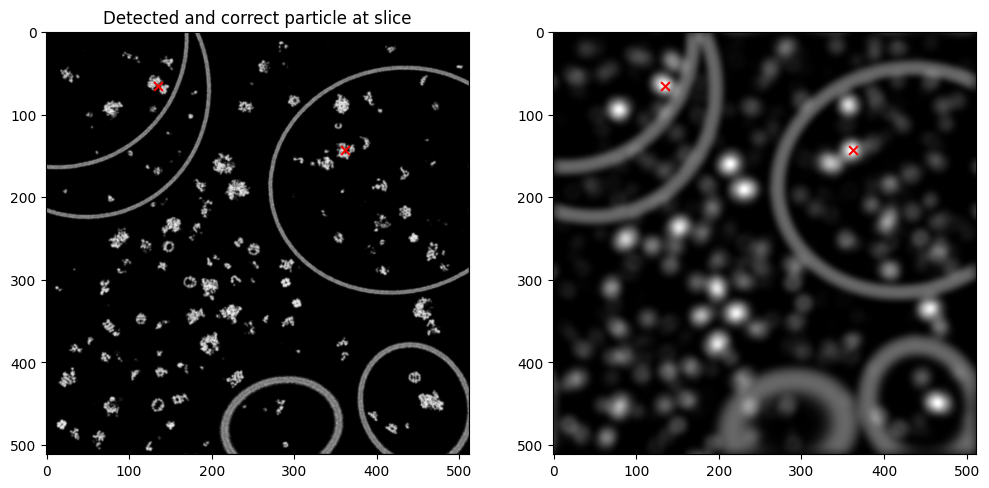

In [19]:
print(peaks_ri[0])

slice_id = 77
print(slice_id)


#x_coord, y_coord = y_coord, x_coord  # swapped in pea
# ks


# take all peaks that are at mid slice

subset_mask = gt_xyz[list(hits_ri)][:,0] == slice_id
subset_peaks_ri = gt_xyz[list(hits_ri)][subset_mask]



# Mark the peaks on the image
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].imshow(grand_model[slice_id], cmap="gray")
ax[0].scatter(subset_peaks_ri[:,2], subset_peaks_ri[:,1], c='r', s=40, marker='x')
ax[0].set_title("Detected and correct particle at slice")
ax[1].imshow(cc_ri[slice_id], cmap="gray")
ax[1].scatter(subset_peaks_ri[:,2], subset_peaks_ri[:,1], c='r', s=40, marker='x')

In [55]:
# def unwrap_fft_coords(peaks, shape):
#     """
#     Convert FFT-wrapped coordinates to spatial coordinates
#     """
#     peaks = peaks.clone()
#     for d in range(3):
#         peaks[:, d] = (peaks[:, d] + shape[d]//2) % shape[d]
#     return peaks

In [56]:
# top_std_unwrapped = unwrap_fft_coords(top_std, cc_std.shape)
# top_ri_unwrapped  = unwrap_fft_coords(top_ri,  cc_ri.shape)

In [57]:
# dist_std, hits_std = evaluate_detections(
#     top_std_unwrapped.cpu().numpy(),
#     gt_xyz,
#     max_dist=8
# )

# dist_ri, hits_ri = evaluate_detections(
#     top_ri_unwrapped.cpu().numpy(),
#     gt_xyz,
#     max_dist=8
# )

# print("STD hits:", hits_std)
# print("RI  hits:", hits_ri)

In [20]:


# Loading GT
gt = pd.read_csv(
    "particle_locations.txt",
    sep=r"\s+",
    header=None,
    names=["label", "z", "y", "x", "rot1", "rot2", "rot3"]
)

# Trying out  a different template
TEMPLATE_LABEL = "5MRC"

gt_target = gt[gt["label"] == TEMPLATE_LABEL]
gt_xyz = gt_target[["x", "y", "z"]].values

print("Evaluating protein:", TEMPLATE_LABEL)
print("GT count:", len(gt_xyz))

Evaluating protein: 5MRC
GT count: 131


In [21]:

from scipy.spatial import cKDTree

def evaluate_detections(detected_xyz, gt_xyz, max_dist=8):
    tree = cKDTree(gt_xyz)
    matched_gt = set()
    distances = []

    for p in detected_xyz:
        dist, idx = tree.query(p, k=1)
        if dist <= max_dist and idx not in matched_gt:
            matched_gt.add(idx)
            distances.append(dist)

    return np.array(distances), len(matched_gt)

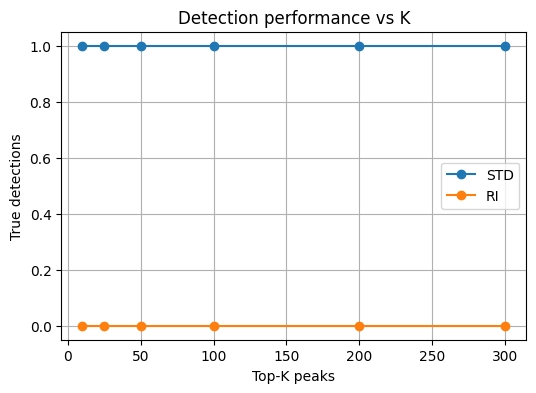

In [22]:


Ks = [10, 25, 50, 100, 200, 300]
hits_std, hits_ri = [], []

for K in Ks:
    top_std = peaks_std[0][peaks_std[1].argsort(descending=True)[:K]] + template.shape[0]//2
    top_ri  = peaks_ri[0][peaks_ri[1].argsort(descending=True)[:K]]  + template.shape[0]//2

    _, h_std = evaluate_detections(top_std.cpu().numpy(), gt_xyz, max_dist=8)
    _, h_ri  = evaluate_detections(top_ri.cpu().numpy(),  gt_xyz, max_dist=8)

    hits_std.append(h_std)
    hits_ri.append(h_ri)

# Plot
plt.figure(figsize=(6,4))
plt.plot(Ks, hits_std, marker="o", label="STD")
plt.plot(Ks, hits_ri,  marker="o", label="RI")
plt.xlabel("Top-K peaks")
plt.ylabel("True detections")
plt.title("Detection performance vs K")
plt.legend()
plt.grid(True)
plt.show()

In [23]:
def extract_patch(volume, center, size=32):
    z, y, x = map(int, center)
    h = size // 2
    return volume[z-h:z+h, y-h:y+h, x-h:x+h]

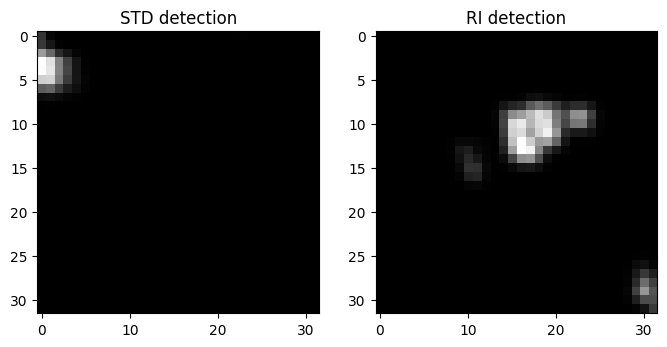

In [24]:
# Picking one mid-ranked detection (not rank 1, often fiducial)
idx = 30

z_std, y_std, x_std = top_std[idx].cpu().numpy().astype(int)
z_ri,  y_ri,  x_ri  = top_ri[idx].cpu().numpy().astype(int)

patch_std = extract_patch(grand_model, (z_std, y_std, x_std))
patch_ri  = extract_patch(grand_model, (z_ri,  y_ri,  x_ri))

fig, axs = plt.subplots(1,2, figsize=(8,4))
axs[0].imshow(patch_std[patch_std.shape[0]//2], cmap="gray")
axs[0].set_title("STD detection")
axs[1].imshow(patch_ri[patch_ri.shape[0]//2], cmap="gray")
axs[1].set_title("RI detection")
plt.show()

In [25]:
# Loading reconstruction for comparison

rec = mrcfile.open("reconstruction.mrc", permissive=True).data.copy()

# reconstruction ≈ grand_model shifted by ~166 voxels in z
Z_OFFSET = 166

/workspaces/fle3d-experiment1/.venv/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:206: RuntimeWarning: Map ID string not found - not an MRC file, or file is corrupt
  warnings.warn(msg, RuntimeWarning)
/workspaces/fle3d-experiment1/.venv/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:216: RuntimeWarning: Unrecognised machine stamp: 0x00 0x00 0x00 0x00
  warnings.warn(str(err), RuntimeWarning)


In [26]:
cc_std_rec, _ = compute_cc(rec, template)
cc_ri_rec,  _ = compute_cc(rec, template_ri)

cc_std_rec = np.maximum(cc_std_rec, 0)
cc_ri_rec  = np.maximum(cc_ri_rec,  0)

print("Reconstruction CC computed")

Computing CC for volumes of shape: (512, 512, 512)
Computing CC for volumes of shape: (512, 512, 512)
Reconstruction CC computed


In [27]:
from torch_find_peaks import find_peaks_3d

peaks_std_rec = find_peaks_3d(cc_std_rec, min_distance=3, threshold_abs=0.02, return_as="torch")
peaks_ri_rec  = find_peaks_3d(cc_ri_rec,  min_distance=3, threshold_abs=0.02, return_as="torch")

In [66]:
TOPK = 250

top_std_rec = peaks_std_rec[0][peaks_std_rec[1].argsort(descending=True)[:TOPK]] + template.shape[0]//2
top_ri_rec  = peaks_ri_rec[0][peaks_ri_rec[1].argsort(descending=True)[:TOPK]]  + template.shape[0]//2

# Shift GT into reconstruction coordinates
gt_xyz_rec = gt_xyz.copy()
gt_xyz_rec[:,0] += Z_OFFSET

_, hits_std_rec = evaluate_detections(top_std_rec.cpu().numpy(), gt_xyz_rec, max_dist=8)
_, hits_ri_rec  = evaluate_detections(top_ri_rec.cpu().numpy(),  gt_xyz_rec, max_dist=8)

print("Reconstruction STD hits:", hits_std_rec)
print("Reconstruction RI  hits:", hits_ri_rec)

Reconstruction STD hits: 3
Reconstruction RI  hits: 1


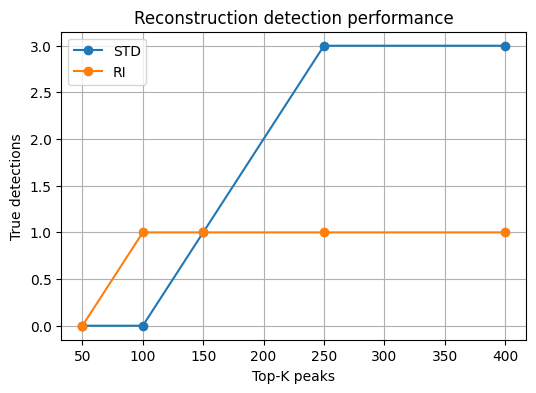

In [67]:
Ks = [50, 100, 150, 250, 400]
hits_std_rec, hits_ri_rec = [], []

for K in Ks:
    top_std_rec = peaks_std_rec[0][peaks_std_rec[1].argsort(descending=True)[:K]] + template.shape[0]//2
    top_ri_rec  = peaks_ri_rec[0][peaks_ri_rec[1].argsort(descending=True)[:K]]  + template.shape[0]//2

    _, h_std = evaluate_detections(top_std_rec.cpu().numpy(), gt_xyz_rec, max_dist=8)
    _, h_ri  = evaluate_detections(top_ri_rec.cpu().numpy(),  gt_xyz_rec, max_dist=8)

    hits_std_rec.append(h_std)
    hits_ri_rec.append(h_ri)

plt.figure(figsize=(6,4))
plt.plot(Ks, hits_std_rec, marker="o", label="STD")
plt.plot(Ks, hits_ri_rec,  marker="o", label="RI")
plt.xlabel("Top-K peaks")
plt.ylabel("True detections")
plt.title("Reconstruction detection performance")
plt.legend()
plt.grid(True)
plt.show()

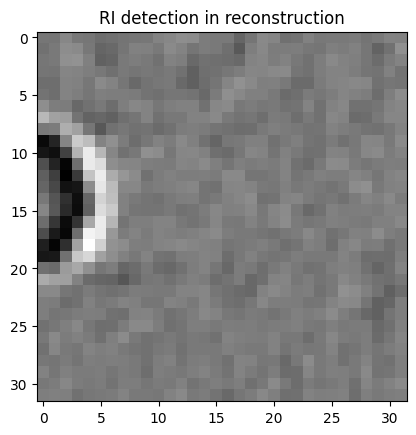

In [68]:
idx = 0
z,y,x = top_ri_rec[idx].cpu().numpy().astype(int)
patch = extract_patch(rec, (z,y,x), size=32)

plt.imshow(patch[patch.shape[0]//2], cmap="gray")
plt.title("RI detection in reconstruction")
plt.show()

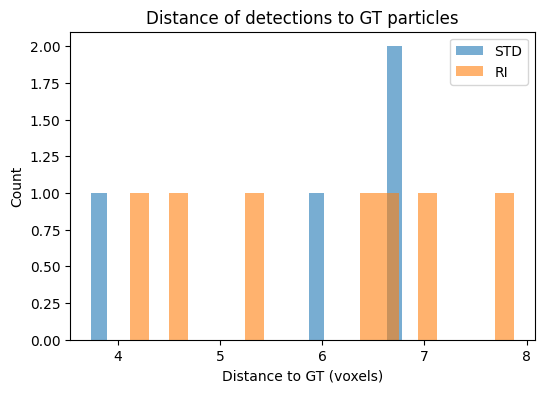

In [ ]:
# Analyzing distances of detections to GT particles

plt.figure(figsize=(6,4))
plt.hist(dist_std, bins=20, alpha=0.6, label="STD")
plt.hist(dist_ri,  bins=20, alpha=0.6, label="RI")
plt.xlabel("Distance to GT (voxels)")
plt.ylabel("Count")
plt.legend()
plt.title("Distance of detections to GT particles")
plt.show()

In [ ]:
#qualitative confirmation 

In [70]:
def extract_patch(volume, center, size=32):
    """
    Extract a cubic patch of shape (size, size, size)
    around a (z, y, x) center.
    """
    z, y, x = map(int, center)
    half = size // 2

    return volume[
        z-half : z+half,
        y-half : y+half,
        x-half : x+half
    ]



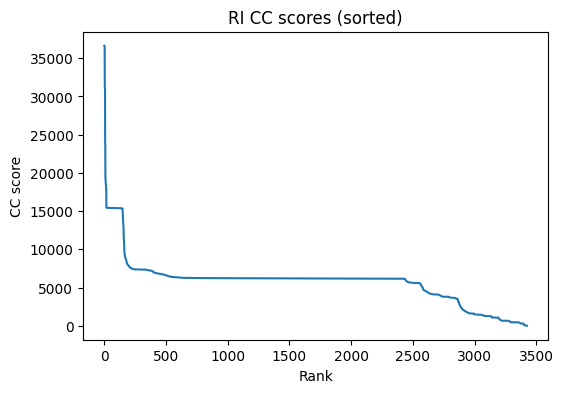

In [ ]:
#Plotting CC score decay (RI)

scores_ri_sorted = peaks_ri[1][peaks_ri[1].argsort(descending=True)]

plt.figure(figsize=(6,4))
plt.plot(scores_ri_sorted.cpu().numpy())
plt.title("RI CC scores (sorted)")
plt.xlabel("Rank")
plt.ylabel("CC score")
plt.show()

In [ ]:
# K top picks with template offset correction
TOPK = 50
template_radius = template.shape[0] // 2

top_std = peaks_std[0][peaks_std[1].argsort(descending=True)[:TOPK]] + template_radius
top_ri  = peaks_ri[0][peaks_ri[1].argsort(descending=True)[:TOPK]] + template_radius

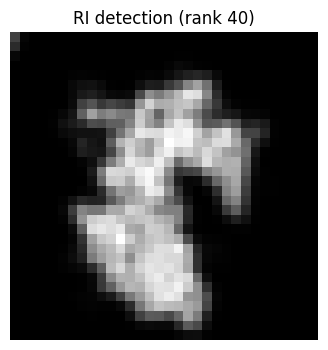

In [ ]:
# Inspecting a mid rank RI detection
score_rank = 40  # mid-ranked peak

patch_ri = extract_patch(
    grand_model,
    top_ri[score_rank],
    size=32
)

plt.figure(figsize=(4,4))
plt.imshow(patch_ri[16], cmap="gray")
plt.title(f"RI detection (rank {score_rank})")
plt.axis("off")
plt.show()

In [ ]:

def center_crop(vol, size):
    c = np.array(vol.shape) // 2
    h = size // 2
    return vol[
        c[0]-h : c[0]+h,
        c[1]-h : c[1]+h,
        c[2]-h : c[2]+h
    ]

template_ri_32 = center_crop(template_ri, 32)
template_std_32 = center_crop(template, 32)

print(template_ri_32.shape, patch_ri.shape)

(32, 32, 32) (32, 32, 32)


In [ ]:
#Proving FFT_CC is correct
dot_ri = np.sum(patch_ri * template_ri_32)

cc_score_ri = peaks_ri[1][peaks_ri[1].argsort(descending=True)[score_rank]]

print(f"RI dot product: {dot_ri:.3f}")
print(f"RI CC score  : {cc_score_ri:.3f}")

RI dot product: 15406.901
RI CC score  : 15406.900


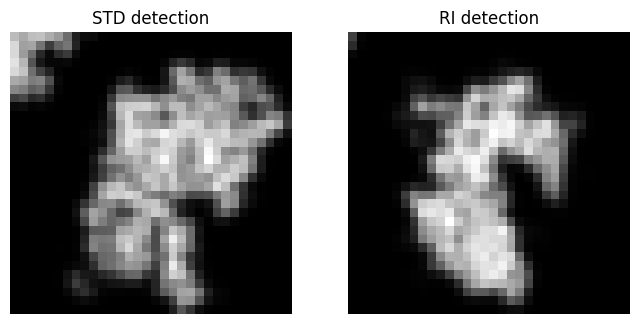

In [ ]:
#Comparing with std at same rank

patch_std = extract_patch(
    grand_model,
    top_std[score_rank],
    size=32
)

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(patch_std[16], cmap="gray")
plt.title("STD detection")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(patch_ri[16], cmap="gray")
plt.title("RI detection")
plt.axis("off")

plt.show()

In [ ]:
# STD dot-product check
dot_std = np.sum(patch_std * template_std_32)

cc_score_std = peaks_std[1][peaks_std[1].argsort(descending=True)[score_rank]]

print(f"STD dot product: {dot_std:.3f}")
print(f"STD CC score  : {cc_score_std:.3f}")

STD dot product: 17251.281
STD CC score  : 17251.300


/workspaces/fle3d-experiment1/.venv/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:206: RuntimeWarning: Map ID string not found - not an MRC file, or file is corrupt
  warnings.warn(msg, RuntimeWarning)
/workspaces/fle3d-experiment1/.venv/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:216: RuntimeWarning: Unrecognised machine stamp: 0x00 0x00 0x00 0x00
  warnings.warn(str(err), RuntimeWarning)


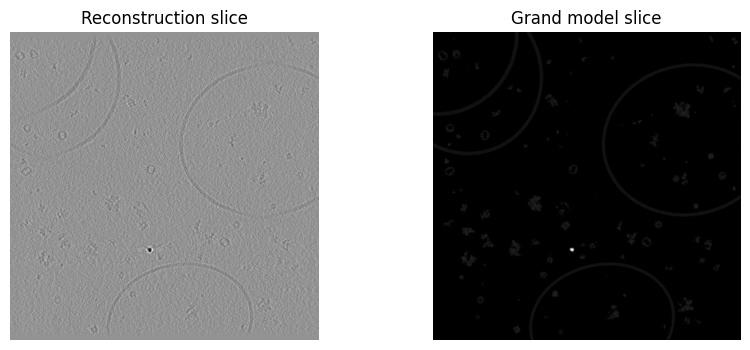

In [84]:
# qualitative comparison of reconstruction vs grand model
#Coordinate alignment: grand_model vs reconstruction

rec = mrcfile.open("reconstruction.mrc", permissive=True).data
grand_model = mrcfile.open("grandmodel.mrc", permissive=True).data

id = 160  # arbitrary slice index

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(rec[166 + id], cmap="gray")
plt.title("Reconstruction slice")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(grand_model[id], cmap="gray")
plt.title("Grand model slice")
plt.axis("off")

plt.show()